In [163]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [164]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Train 50k, test 10k
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


Class encoding:
0 - airplane
1 - automobile
2 - bird
3 - cat
4 - deer
5 - dog
6 - frog
7 - horse
8 - ship
9 - truck

In [165]:
# Split training data into training and validation sets
num_validation_samples = int(0.2 * train_images.shape[0])  # 20% of the training dataset (40k:10k)

val_images = train_images[:num_validation_samples]
val_labels = train_labels[:num_validation_samples]

train_images = train_images[num_validation_samples:]
train_labels = train_labels[num_validation_samples:]

# One-hot label encoding (10 labels)
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)


In [166]:
# Create tf.data.Dataset objects
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = (
    train_dataset
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [167]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

## My attempts

In [168]:
# inputs = keras.Input(shape=(32, 32, 3))
# 
# x = data_augmentation(inputs)
# 
# # Normalize pixel values to be between 0 and 1
# x = layers.Rescaling(1./255)(x)
# 
# x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
# 
# x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
# x = layers.MaxPooling2D(pool_size=2)(x)
# 
# x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
# 
# x = layers.Flatten()(x)
# x = layers.Dropout(0.25)(x)
# outputs = layers.Dense(10, activation="softmax")(x)
# 
# model = keras.Model(inputs=inputs, outputs=outputs)
# 
# model.summary()
# 
# model.compile(loss="categorical_crossentropy",
#               optimizer="adam",
#               metrics=["accuracy"])

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_18 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 rescaling_17 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_67 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 13, 13, 64)        18496     
                                                          

## From web, 80% accuracy

In [170]:
inputs = keras.Input(shape=(32, 32, 3)) # Updated for grayscale images

x = data_augmentation(inputs)

# Normalize pixel values to be between 0 and 1
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.2)(x)

# Second conv block
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

# Third conv block
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.4)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_18 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 rescaling_18 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                          

In [171]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.002, restore_best_weights=True)

history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[callback])

Epoch 1/80
1250/1250 [==============================] - 19s 11ms/step - loss: 1.9741 - accuracy: 0.2792 - val_loss: 1.5933 - val_accuracy: 0.4172
Epoch 2/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.6629 - accuracy: 0.3906 - val_loss: 1.6015 - val_accuracy: 0.4481
Epoch 3/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5107 - accuracy: 0.4509 - val_loss: 1.3412 - val_accuracy: 0.5106
Epoch 4/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.4115 - accuracy: 0.4968 - val_loss: 1.2978 - val_accuracy: 0.5547
Epoch 5/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.3241 - accuracy: 0.5327 - val_loss: 1.2100 - val_accuracy: 0.5805
Epoch 6/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.2508 - accuracy: 0.5667 - val_loss: 1.0475 - val_accuracy: 0.6430
Epoch 7/80
1250/1250 [==============================] - 13s 10ms/step - loss: 1.1791 - accuracy: 0.5922 - val_loss: 0.9787 -

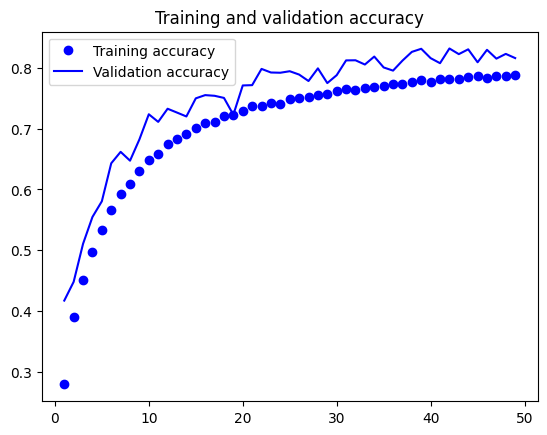

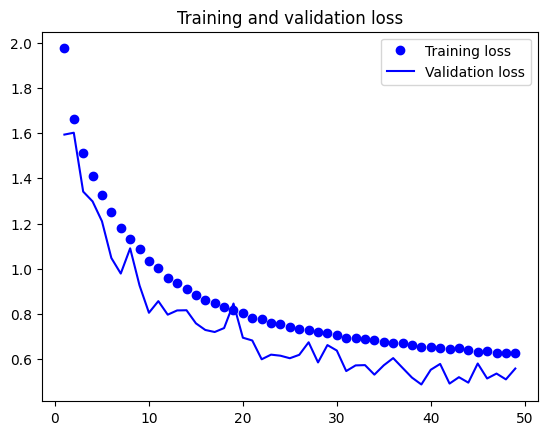

In [172]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [173]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy: is", test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.5184 - accuracy: 0.8239
Test accuracy: is 0.8238999843597412
